In [1]:
import time as time
import numpy as np
import os
from Tools import Tools

import os
os.chdir("/Users/33761/Desktop/Projet_Algo_Ung/instances")

# Declaration de variable globale:
CASE_WHITE = -1
CASE_EMPTY = 0
CASE_BLACK = 1


class GrilleNonResolvable(Exception):
    """Leve une Exception en cas de Grille non resolvable"""
    def __init__(self, message):
        Exception.__init__(self, message)


# Declaration de fonction:
def T_without_color(j, l, ligne, sequence):
    """ Entree : j          = indice de la j+1 premieres cases. 
                 l          = indice bloc des li premiers blocs.
                 ligne      = 
                 sequence   = Sequence de la ligne li (s1,...,sl).
        Sortie : Retourne True si il y a un coloriage possible d'une ligne non coloriée avec une sequence
                 donnée sinon retourne False.
    """ 
    # Sequence vide :
    if l == 0:
        return True
    # Au moins un bloc dans sequence de la ligne l(i)
    if l >= 1:
        if j < sequence[l-1]-1 :  
            return False
        # Deux conditions pour le cas j == sequence[l-1]-1 :
        if j == sequence[l-1]-1 and l == 1:
            return True
        if j == sequence[l-1]-1 and l > 1:
            return False
        # On considère la ligne l(i) vide :
        if j > sequence[l-1] -1:
            return  T_without_color(j-1, l, ligne, sequence) or T_without_color(j-(sequence[l-1])-1, l-1, ligne, sequence)

In [2]:
#Test function T_without_color(j, l, ligne, sequence) :
ligne = [0,0,0,0]
sequence = [2,1]
print(T_without_color(3, 2, ligne, sequence))

True


In [3]:
def Top_Down(ligne, sequence, memoire_cache):
    j, l = len(ligne), len(sequence)    
    # On regarde si la clef (j,l) a deja ete calcule:
    if (j,l) in memoire_cache :
        return memoire_cache[(j,l)]
    # Si la clef n'a pas ete calcule ulterieurement:
    if l == 0:
        memoire_cache[(j,l)] = np.all(ligne <= 0)
    elif j < sequence[-1]:
        memoire_cache[(j,l)] =  False
    elif l==1 and j == sequence[-1]:
        memoire_cache[(j,l)] =  np.all(ligne >= 0)
    elif l > 1 and j == sequence[-1]:
        memoire_cache[(j,l)] =  False
    elif j > sequence[-1]:
        if ligne[j - 1] == CASE_WHITE:
            memoire_cache[(j,l)] =  Top_Down(ligne[:j - 1],sequence,memoire_cache)
        else :
            if ligne[j-1] == CASE_EMPTY and (j-1,l) in memoire_cache :
                memoire_cache[(j,l)] = memoire_cache[(j-1,l)]
            else :
                # Decomposition de la condition en plusieur variable :
                insert_bloc = np.all(ligne[j-sequence[-1]:] >= 0)
                one_bloc = l==1 and np.all(ligne[:j-sequence[-1]] <=0)
                several_bloc = (ligne[j-sequence[-1]-1] <= 0) and \
                            Top_Down(ligne[:j - sequence[-1] - 1],sequence[:-1],memoire_cache)
                # Condition final pour validation :
                condition = insert_bloc and (one_bloc or several_bloc)
                if ligne[j - 1] == CASE_BLACK:
                    memoire_cache[(j,l)] = condition
                elif ligne[j - 1] == CASE_EMPTY:
                    memoire_cache[(j,l)] =  condition or Top_Down(ligne[:j - 1],sequence,memoire_cache)
    return memoire_cache[(j,l)]

def Top_Down_Init(ligne, sequence):
    return Top_Down(ligne, sequence,{})

In [4]:
def Coloration(grille,sequences_lignes, sequences_colonnes, indiceAVoir) :
    indiceAajouter = set()
    for i in indiceAVoir:
        # Récupere seulement les case à qui sont non coloriée :
        # la fonction where, nous donne l'indice de ces cases non coloriées :
        for j in np.where(grille[i] == CASE_EMPTY)[0]:
            # Recupere les sequences d'une ligne et une colonne pour la case (i,j)
            lig = sequences_lignes[i]
            col = sequences_colonnes[j]
            # Test avec une case (i,j) BLACK :
            grille[i][j] = CASE_BLACK
            test_black = Top_Down_Init(grille[i],lig) and Top_Down_Init(np.transpose(grille)[j], col)
            # Test avec une case (i,j) White :
            grille[i][j] = CASE_WHITE
            test_white =  Top_Down_Init(grille[i],lig) and Top_Down_Init(np.transpose(grille)[j], col)
            if not test_black and not test_white:
                # Leve une exception en cas de grille non resolvable:
                # Cette exception est rattraper dans le main
                raise GrilleNonResolvable("Grille non resolvable pour la ligne "+i+",la colonne "+j)
            elif test_black and test_white:
                # Impossible de decider de la couleur de la case :
                grille[i][j] = CASE_EMPTY
                #indiceAajouter.add(j) #pour pouvoir afficher le chien 
            elif test_black and not test_white:
                grille[i][j] = CASE_BLACK
                indiceAajouter.add(j) 
            else:
                grille[i][j] = CASE_WHITE
                indiceAajouter.add(j) 
    return indiceAajouter              

def propagation (sequences_lignes, sequences_colonnes) :
    # Récupere la taille des contraintes sur les lignes et colonnes : 
    N, M = len(sequences_lignes), len(sequences_colonnes)
    # Initialisation de la grille avec une valeur de type CASE_EMPTY = 0 :
    grille = np.full((N, M), CASE_EMPTY)
    # Initialisation des lignes et colonnes a voir :
    # On choisit de prendre la fonction set() afin de ne pas avoir de doublons 
    lignesAVoir, colonnesAVoir = set(range(N)), set()
    # Debut d'Algorithme :
    while lignesAVoir or colonnesAVoir:
        # Test toute les lignes et retourne les colonnes a voir,
        #c'est à dire les colonnes ou les case (i,j) d'une ligne ont été modifié:
        colonnesAVoir = Coloration(grille, sequences_lignes, sequences_colonnes,lignesAVoir)
        # Les lignes étant toute parcourut, on met l'ensemble à vide
        lignesAVoir = set()
        # Test toute les colonnes:
        #c'est à dire les lignes ou les case (i,j) d'une colonnes ont été modifié:
        lignesAVoir = Coloration(np.transpose(grille), sequences_colonnes, sequences_lignes, colonnesAVoir)
        colonnesAVoir = set()
    return grille

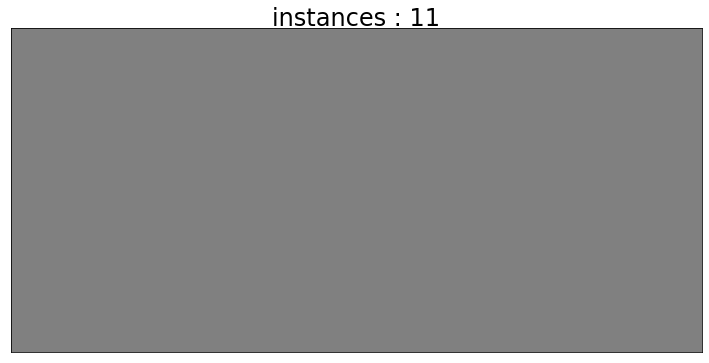

0.0


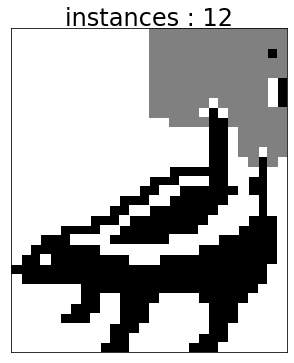

1.9889025688171387


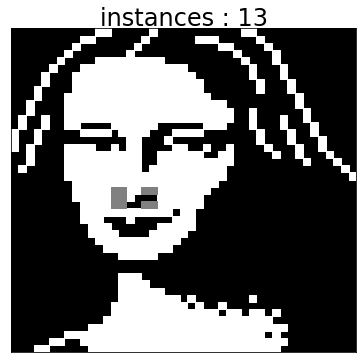

2.5085864067077637


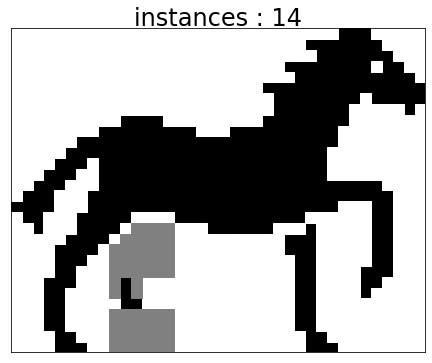

1.2443675994873047


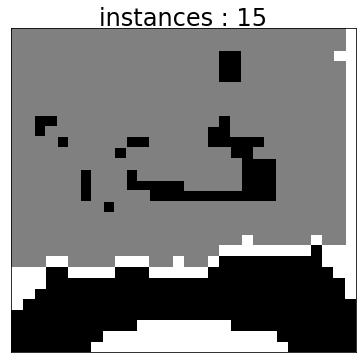

0.9943487644195557


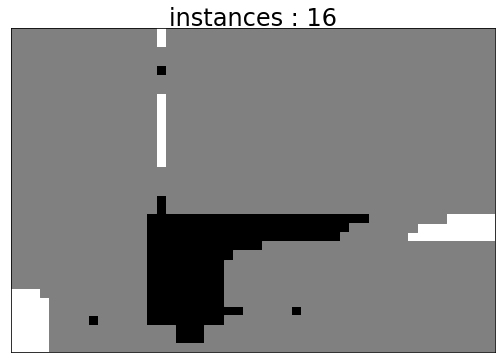

2.7332053184509277


In [5]:
tools = Tools()
for i in range(0,11):
    nom_fichier = str(i)+".txt"
    sequences_lignes, sequences_colonnes = tools.parse_instance(nom_fichier)
    try :
        t1 = time.time()
        grille = propagation(sequences_lignes, sequences_colonnes)
        t2 = time.time()
    except GrilleNonResolvable :
        print("Exception : Grille non Resolvable")
    tools.affichage(grille,"instances : "+str(i))
    print(t2-t1)

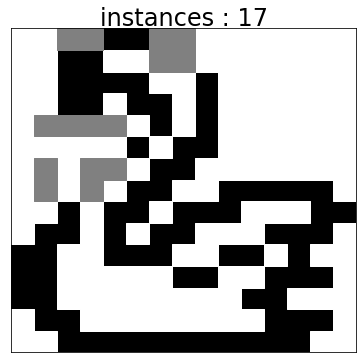

0.32063937187194824


In [7]:
tools = Tools()
i = "17"
nom_fichier = str(i)+".txt"
sequences_lignes, sequences_colonnes = tools.parse_instance(nom_fichier)
try :
    t1 = time.time()
    grille = propagation(sequences_lignes, sequences_colonnes)
    t2 = time.time()
except GrilleNonResolvable :
    print("Exception : Grille non Resolvable")
tools.affichage(grille,"instances : "+str(i))
print(t2-t1)